In [1]:
import os
print(os.getcwd())

import torch
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from models.Bs import Bs
from models.Cev import Cev
from models.Nig import Nig
import matplotlib.pyplot as plt

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis


# ADVI: BS

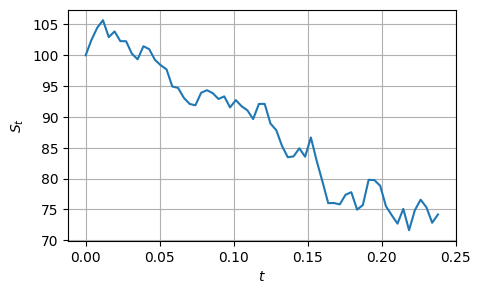

In [15]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
model = Bs(dt=dt)
T = 30 / 252

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 0.2]])
S1 = model.simulate(params, S0, T, M=1)
t1 = len(S1)

params = torch.tensor([[-0.1, 0.5]])
S2 = model.simulate(params, S1[-1], T, M=1)

S = torch.concatenate([S1[:, 0], S2[:, 0]])

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

/var/folders/vy/fmgkssl15p50c836x934qygw0000gn/T/ipykernel_91447/1585034124.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  logS = np.log(S_obs)


/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/rich/live.py:
231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = -79.408


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

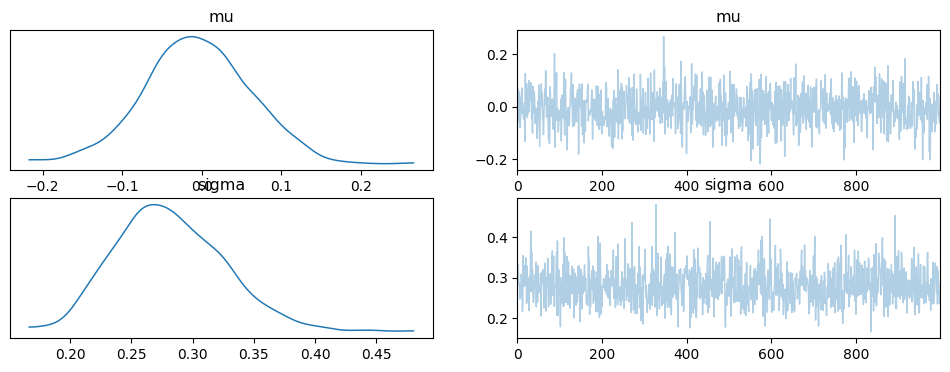

In [16]:
# Example data: historical spot prices
S_obs = S[:t1] # your spot price series
dt = 1/252  # daily data for example

logS = np.log(S_obs)
log_returns = logS[1:] - logS[:-1]

with pm.Model() as model:
    # Priors
    mu = pm.Normal("mu", mu=0.0, sigma=0.05)
    sigma = pm.LogNormal("sigma", mu=np.log(0.5), sigma=0.3)

    # Mean and variance of log returns
    mu_dt = (mu - 0.5 * sigma**2) * dt
    var_dt = sigma**2 * dt

    # Likelihood
    pm.Normal("log_returns", mu=mu_dt, sigma=pt.sqrt(var_dt), observed=log_returns)

with model:
    approx = pm.fit(method="fullrank_advi", n=20000)
    trace = approx.sample(1000)

import arviz as az
az.plot_trace(trace)

# SVGD: BS

In [17]:
with pm.Model() as bs_model_svgd:
    S_data = pm.Data("S_obs", S)

    mu = pm.Normal("mu", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Log returns
    r = pt.log(S_data[1:] / S_data[:-1])

    pm.Normal(
        "obs",
        mu=(mu - 0.5 * sigma**2) * dt,
        sigma=sigma * pt.sqrt(dt),
        observed=r
    )

svgd = pm.SVGD(
    model=bs_model_svgd,
    n_particles=200,       # number of particles
    jitter=1e-3,           # initial jitter for particles
    random_seed=42,
)

approx_svgd = svgd.fit(
    n=500,                 # number of SVGD iterations
    obj_optimizer=pm.adam(learning_rate=1e-2),
    obj_n_mc=1,
    tf_n_mc=1,
    progressbar=True,
)

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/pymc/variational/opvi.py:190: UserWarning: `tf_n_mc` is not used for KSD[Empirical] and ignored
  warnings.warn(f"`{smth}` is not used for {where} and ignored")


/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/rich/live.py:
231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

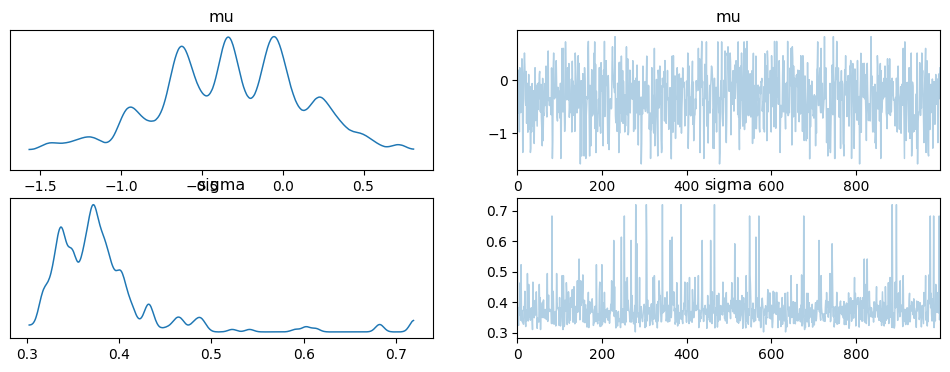

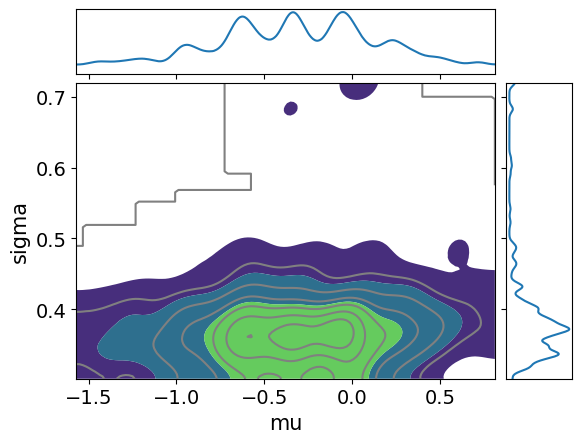

In [18]:
trace = approx_svgd.sample(1000)
az.plot_trace(trace)
import arviz as az
az.plot_pair(trace, var_names=["mu", "sigma"], kind="kde", marginals=True)

Little access to hyperparameter fine tuning (bandwidth). Also hard to monitor, no access to particles.  
Not clear which default hyperparameters they use but the results are not satisfying.  
Also very slow.

# ADVI: CEV

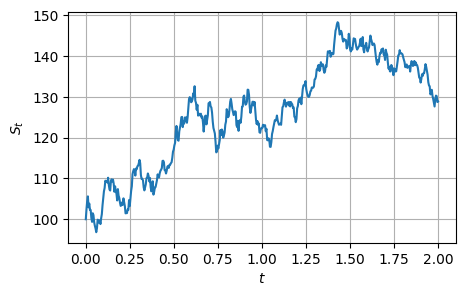

In [4]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
cev_model = Cev(dt=dt)
T = 1.0

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 2.0, 1.0]])
S1 = cev_model.simulate(params, S0, T, M=1)
t1 = len(S1)

params = torch.tensor([[-0.1, 5.0, 0.5]])
S2 = cev_model.simulate(params, S1[-1], T, M=1)

S = torch.concatenate([S1[:, 0], S2[:, 0]])

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

/var/folders/vy/fmgkssl15p50c836x934qygw0000gn/T/ipykernel_91447/1427117476.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  logS = np.log(S_obs)


/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/rich/live.py:
231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 441.26


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

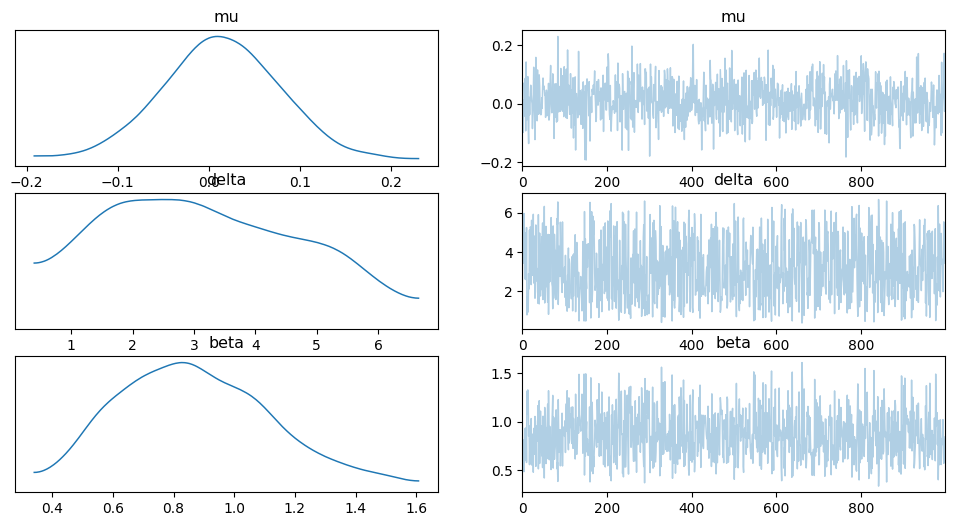

In [7]:
# Example data: historical spot prices
S_obs = S[:t1] # your spot price series
dt = 1/252  # daily data for example

logS = np.log(S_obs)
log_returns = logS[1:] - logS[:-1]

with pm.Model() as model:
    S_obs_data = pm.Data("S_obs_data", S_obs)

    # Priors
    mu = pm.Normal("mu", mu=0.0, sigma=0.05)
    delta = pm.Uniform("delta", lower=0.2, upper=7.0)
    beta = pm.Uniform("beta", lower=0.2, upper=2.0)

    # Likelihood
    mean = S_obs_data[:-1] + mu * S_obs_data[:-1] * dt
    std = delta * S_obs_data[:-1]**(beta / 2) * pt.sqrt(dt)

    pm.Normal('S_obs', mu=mean, sigma=std, observed=S_obs_data[1:])

with model:
    approx = pm.fit(method="fullrank_advi", n=20000)
    #approx = pm.fit(method="advi", n=20000)
    trace = approx.sample(1000)

import arviz as az
az.plot_trace(trace)

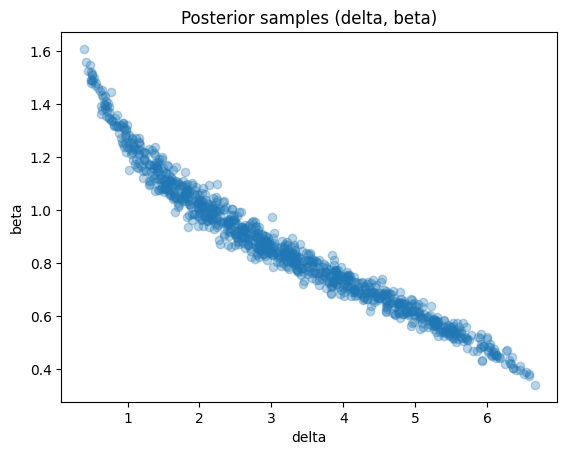

In [10]:
delta_samples = trace.posterior['delta'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()

plt.scatter(delta_samples, beta_samples, alpha=0.3)
plt.xlabel('delta')
plt.ylabel('beta')
plt.title('Posterior samples (delta, beta)')
plt.show()


# ELBO: BS

In [5]:
import logging
import os
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

from models.Bs import Bs

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

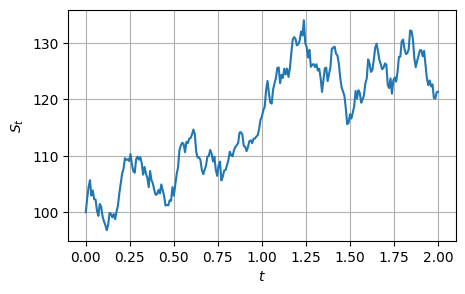

In [6]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
model = Bs(dt=dt)
T = 252 / 252

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 0.2]])
S = model.simulate(params, S0, T, M=1)[:, 0]

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

In [7]:
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# log-returns
r = torch.log(S[1:] / S[:-1])

def black_scholes_model(data):
    mu_year = pyro.sample("mu", dist.Normal(0., 0.05))       # Annual drift
    sigma_year = pyro.sample("sigma", dist.HalfNormal(1.))   # Annual vol

    mu_daily = mu_year / 252
    sigma_daily = sigma_year / torch.sqrt(torch.tensor(252.))

    mean = mu_daily - 0.5 * sigma_daily**2

    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Normal(mean, sigma_daily), obs=data)

Step 0, Loss: -500.26394444704056
Step 100, Loss: -663.6010967493057
Step 200, Loss: -739.7471361756325
Step 300, Loss: -740.0889226198196
Step 400, Loss: -739.5082417726517
Step 500, Loss: -740.014312684536
Step 600, Loss: -740.2389137744904
Step 700, Loss: -739.3409704566002
Step 800, Loss: -739.3359923958778
Step 900, Loss: -739.0548955798149
Step 1000, Loss: -739.6636677980423
Step 1100, Loss: -739.280410528183
Step 1200, Loss: -739.9944714903831
Step 1300, Loss: -740.0827389955521
Step 1400, Loss: -739.8989859223366
Step 1500, Loss: -739.042950451374
Step 1600, Loss: -739.5398066043854
Step 1700, Loss: -739.4532712101936
Step 1800, Loss: -739.8576633930206
Step 1900, Loss: -740.0599071979523


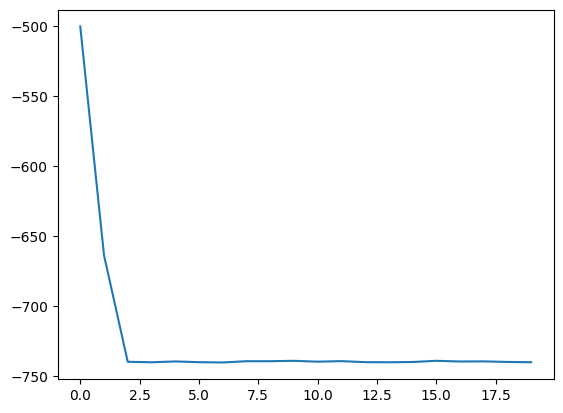

In [8]:
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(black_scholes_model)     # guide = variational family

optimizer = Adam({"lr": 0.01})
svi = SVI(black_scholes_model, guide, optimizer, loss=Trace_ELBO())

num_steps = 2000
loss_history = []
for step in range(num_steps):
    loss = svi.step(r)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")
        loss_history.append(loss)

plt.plot(loss_history)

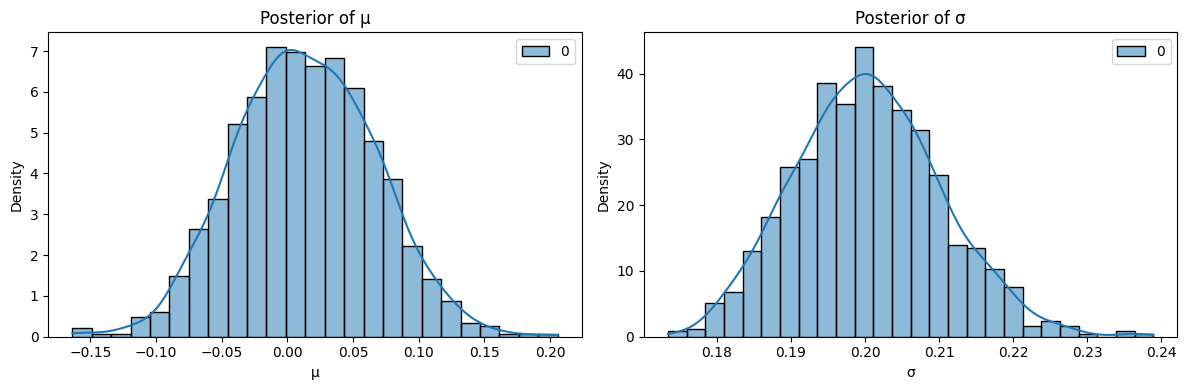

In [9]:
from pyro.infer import Predictive

predictive = Predictive(black_scholes_model, guide=guide, num_samples=1000)
posterior_samples = predictive(r)

mu_samples = posterior_samples["mu"].detach().numpy()
sigma_samples = posterior_samples["sigma"].detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#axes[0].hist(mu_samples, bins=50, density=True)
sns.histplot(mu_samples, kde=True, stat="density", label="mu", ax=axes[0])
axes[0].set_title("Posterior of μ")
axes[0].set_xlabel("μ")
axes[0].set_ylabel("Density")

#axes[1].hist(sigma_samples, bins=50, density=True)
sns.histplot(sigma_samples, kde=True, stat="density", label="sigma", ax=axes[1])
axes[1].set_title("Posterior of σ")
axes[1].set_xlabel("σ")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Pyro SVGD: BS

In [10]:
from pyro.infer import SVGD, RBFSteinKernel
from pyro.optim import Adam

def black_scholes_model(data):
    N = len(data)
    T = torch.tensor(252., device=data.device)

    mu = pyro.sample("mu", dist.Uniform(-0.1, 0.1))        # [P]
    sigma = pyro.sample("sigma", dist.Uniform(0.0, 1.5))   # [P]

    mu_daily = mu / T
    sigma_daily = sigma / torch.sqrt(T)
    mean = mu_daily - 0.5 * sigma_daily**2   # [P]

    # Broadcast to [P, N]
    mean = mean                  # [P, 1]
    sigma_daily = sigma_daily     # [P, 1]
    data = data[None, :]                    # [1, N]

    with pyro.plate("data", N, dim=-1):
        pyro.sample("obs", dist.Normal(mean, sigma_daily), obs=data)



kernel = RBFSteinKernel()
adam = Adam({"lr": 0.1})
svgd = SVGD(black_scholes_model, kernel, adam, num_particles=100, max_plate_nesting=1, mode='multivariate')

for step in range(1000):
    svgd.step(r)

final_particles = svgd.get_named_particles()

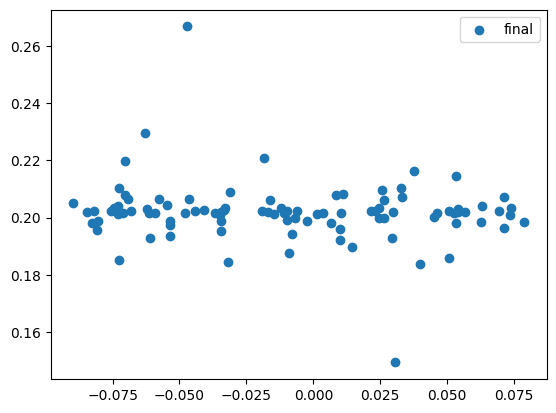

In [11]:
plt.scatter(final_particles["mu"].detach(), final_particles["sigma"].detach(), label='final')
plt.legend()